연습문제 1. Deep Learning 유방암 진단 모델 구축 및 SHAP 설명 얻기
==============================
* XGBoost는 White Box Model이고, Deep Learning Model은 Black Box Model 인 것을 이해하자

In [ ]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 5.2 MB/s 


In [ ]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import shap

USE_CUDA = torch.cuda.is_available()
device = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", device)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using Device: cuda


In [ ]:
epochs = 10
batch_size = 10
learning_rate = 0.01

In [ ]:
cancer = load_breast_cancer()

In [ ]:
# DataFrame으로 만들기
x_data = pd.DataFrame(cancer.data, columns = cancer.feature_names)
y_data = pd.DataFrame(cancer.target)

x_data = (x_data - x_data.mean()) / x_data.std()


x_data, x_test, y_data, y_test =  train_test_split(x_data, y_data, test_size=0.1, shuffle=False)
x_train, x_val, y_train, y_val =  train_test_split(x_data, y_data, test_size=0.1, shuffle=True, stratify = y_data, random_state=34)



In [ ]:
def make_torch(x):
    return  torch.from_numpy(x.to_numpy().astype(np.float32))

trainset = TensorDataset(make_torch(x_train), make_torch(y_train))
valset = TensorDataset(make_torch(x_val), make_torch(y_val))
testset = TensorDataset(make_torch(x_test), make_torch(y_test))

In [ ]:
trainloader = DataLoader(dataset = trainset, batch_size = batch_size, shuffle = True, num_workers = 2)
valloader = DataLoader(dataset = valset, batch_size = batch_size, shuffle = True, num_workers = 2)
testloader = DataLoader(dataset = testset, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.block1 = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.block2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.block3 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5)
        )
        self.output = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        y = self.output(x)
        return self.sigmoid(y)

In [ ]:
model = MLP().to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
criterion = nn.BCELoss() 

In [ ]:
loss_list = []
for epoch in tqdm(range(1, epochs+1)):
    loss_value = 0
    for step, (x, y) in enumerate(trainloader):
        model.train()
        x = x.to(device)
        y = y.to(device)

        pred = model(x)
        
        loss = criterion(pred, y)
        loss_value += loss.item()
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
    loss_list.append(loss_value)
    print("Epoch : ", epoch, ', Loss : ', loss.item())

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch :  1 , Loss :  0.5051038265228271
Epoch :  2 , Loss :  0.0029357420280575752
Epoch :  3 , Loss :  0.0036441998090595007
Epoch :  4 , Loss :  0.00013219506945461035
Epoch :  5 , Loss :  0.002200949937105179
Epoch :  6 , Loss :  0.017034128308296204
Epoch :  7 , Loss :  0.005207804497331381
Epoch :  8 , Loss :  0.006355404853820801
Epoch :  9 , Loss :  0.05131445452570915
Epoch :  10 , Loss :  0.0008418849902227521


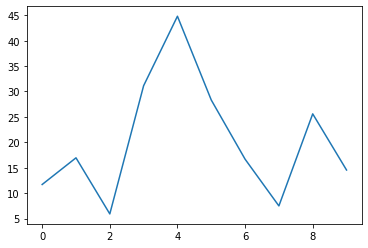

In [ ]:
plt.plot(loss_list)

In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    for x, y in valset:
        x = x.to(device)
        pred.append(int(model(x).detach().cpu().item()))
accuracy = accuracy_score(y_val, pred)
print('Validation Accuracy: %.2f%%' % (accuracy * 100.0))

Validation Accuracy: 96.15%


In [ ]:
with torch.no_grad():
    model.eval()
    pred = []
    for x, y in testset:
        x = x.to(device)
        pred.append(int(model(x).detach().cpu().item()))
accuracy = accuracy_score(y_test, pred)
print('Test Accuracy: %.2f%%' % (accuracy * 100.0))

Test Accuracy: 91.23%


In [ ]:
shap.initjs()
# Define function to wrap model to transform data to tensor
f = lambda x: model( Variable( torch.from_numpy(x) ) ).detach().numpy()

In [ ]:
model = model.to('cpu')
x_test = x_test.astype(np.float32)
explainer = shap.KernelExplainer(f, x_test)

In [ ]:
shap_values = explainer.shap_values(x_test)

  0%|          | 0/57 [00:00<?, ?it/s]

The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight

In [ ]:
print(len(shap_values))
print(shap_values[0].shape)

1
(57, 30)


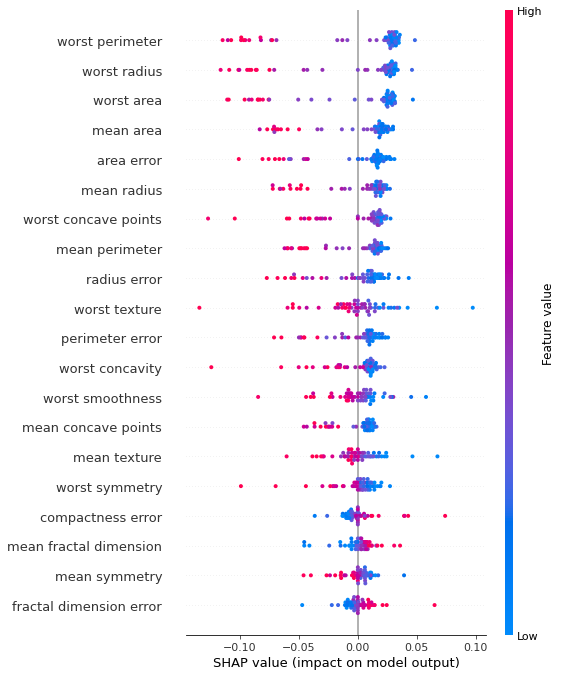

In [ ]:
shap.summary_plot(shap_values[0], x_test, cancer.feature_names)